# Distributed CBO -- Benchmark and Comparison

In [1]:
%load_ext autoreload
%autoreload 2

import math
import time

import matplotlib.pyplot as plt
import numpy as np

from cbx.dynamics import CBO, DistributedCBO
from cbx.objectives import Rastrigin, Ackley, Michalewicz
import cbx.utils.termination as term

# CBO Configuration

In [2]:
conf = {
    'alpha': 40.0,
    'dt': 0.1,
    'sigma': 1.,
    'lamda': 1.0,
    'd': 20,
    'term_criteria': [term.max_it_term(100)],
    'track_args': {'names': ['update_norm', 'energy', 'x', 'consensus', 'drift']},

    'noise': 'anisotropic',
    'f_dim': '3D'
}

# Define Objective Function

In [3]:
f = Ackley()

In [4]:
# Benchmarking params
NUM_RUNS = 500
MAX_SPLITTING_FACTOR = 10
MAX_PARTICLES = 100
SYNCHRONIZATION_INTERVAL = 10
SYNCHRONIZATION_METHOD = 'weighted_mean'

In [5]:
def benchmark_distributed_cbo(
    num_runs: int = NUM_RUNS,
    max_splitting_factor: int = MAX_SPLITTING_FACTOR,
    max_particles: int = MAX_PARTICLES,
    synchronization_interval: int = SYNCHRONIZATION_INTERVAL,
    synchronization_method: str = SYNCHRONIZATION_METHOD,
):
    energy_means = []
    execution_times = []
    for splitting_factor in range(1, max_splitting_factor + 1):
        num_particles = math.ceil(max_particles / splitting_factor)
        energies = []
        for _ in range(num_runs):
            dyn = DistributedCBO(
                f=f,
                num_agent_batches=splitting_factor,
                synchronization_interval=synchronization_interval,
                synchronization_method=synchronization_method,
                N=num_particles,
                verbose=False,
                max_it=10000,
                **conf
            )

            # Run optimization and measure time
            tick = time.time()
            energies.append(
                f(dyn.optimize(num_steps=1000000, sched='default'))
            )
            tock = time.time()
            execution_times.append(tock - tick)

        mean_energy = np.mean(energies)
        print(f"Splitting factor: {splitting_factor}, mean energy: {mean_energy}. Execution time: {np.mean(execution_times)}")
        energy_means.append(np.mean(energies))  

    plt.plot(list(range(1, max_splitting_factor + 1)), energy_means, label='Distributed CBO')


In [6]:
def benchmark_standard_cbo(
    num_runs: int = NUM_RUNS,
    num_particles: int = MAX_PARTICLES,
):
    energies = []
    execution_times = []
    for _ in range(num_runs):
        dyn = CBO(
            f,
            N=num_particles,
            verbosity=0,
            max_it=10000,
            batch_args=None,
            M=1,
            **conf
        )

        # Run optimization and measure time
        tick = time.time()
        energies.append(
            f(dyn.optimize())
        )
        tock = time.time()
        execution_times.append(tock - tick)
    print(f"Non distributed mean energy: {np.mean(energies)}. Execution time: {np.mean(execution_times)}")

    # Plot mean of undistributed energies as a horizontal line
    plt.axhline(y=np.mean(energies), color='r', linestyle='--', label='Standard CBO')


# Benchmark

Splitting factor: 1, mean energy: 0.24509835297128751. Execution time: 0.020488012313842775
Splitting factor: 2, mean energy: 0.19219572705451096. Execution time: 0.023636493921279908
Splitting factor: 3, mean energy: 0.18196716461546233. Execution time: 0.028554325739542644
Splitting factor: 4, mean energy: 0.19822614066218644. Execution time: 0.03255797374248505
Splitting factor: 5, mean energy: 0.20215584145489945. Execution time: 0.036924224853515625
Splitting factor: 6, mean energy: 0.20766641666768054. Execution time: 0.04162171077728272
Splitting factor: 7, mean energy: 0.21014297614300953. Execution time: 0.046809125423431394
Splitting factor: 8, mean energy: 0.22168565478726157. Execution time: 0.051689033031463626
Splitting factor: 9, mean energy: 0.22403622785212507. Execution time: 0.05658012082841661
Splitting factor: 10, mean energy: 0.24837173504801902. Execution time: 0.0613699188709259
Non distributed mean energy: 0.24488360448229216. Execution time: 0.0120794401168823

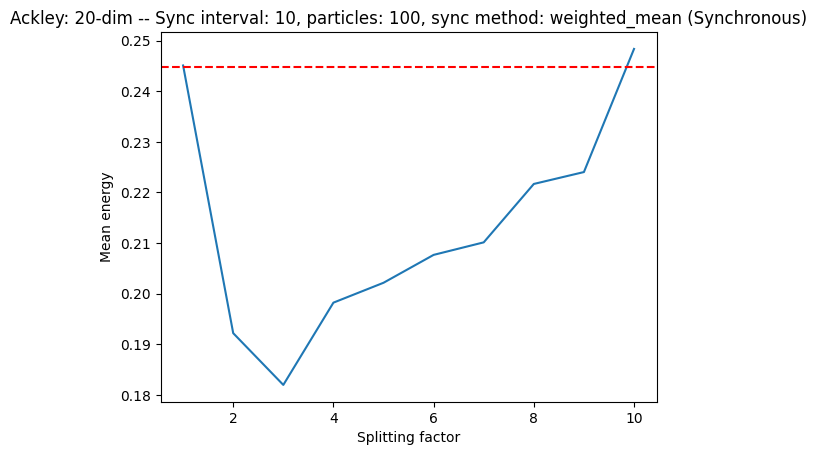

In [7]:
benchmark_distributed_cbo()
benchmark_standard_cbo()

d = conf['d']

plt.xlabel(f"Splitting factor")
plt.ylabel(f"Mean energy")
plt.title(f"Ackley: {d}-dim -- Sync interval: {SYNCHRONIZATION_INTERVAL}, particles: {MAX_PARTICLES}, sync method: {SYNCHRONIZATION_METHOD} (Synchronous)")
plt.show()